# Inertial Navigation
## Accelerometers: Noise and Offsets

In [383]:
import numpy as np
import matplotlib.pyplot as plt
import filterpy.stats as stats
from scipy.integrate import cumtrapz as trapz

In [384]:
# Number of samples
Tend = 10
N = 100
h = Tend/N

# Create a time vector
time = np.linspace(0, Tend, N+1)

Consider a moving object, perhaps a car coming to a stop at traffic lights.

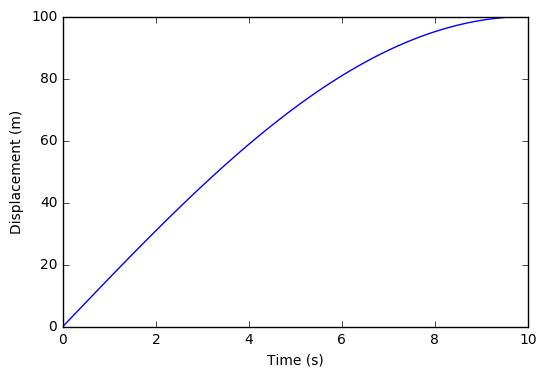

In [385]:
# Displacement
displacement = 100 * np.sin(np.pi/20*time)
# Plot
plt.plot(time[0:N+1], displacement)
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")

The velocity of a particle is the derivative of its displacement with respect to time:

$\Large v(t) = \frac{d}{dt}s(t) = \frac{y_k-y_{k-1}}{t_k-t_{k-1}} = \frac{1}{h} (y_k - y_{k-1})$

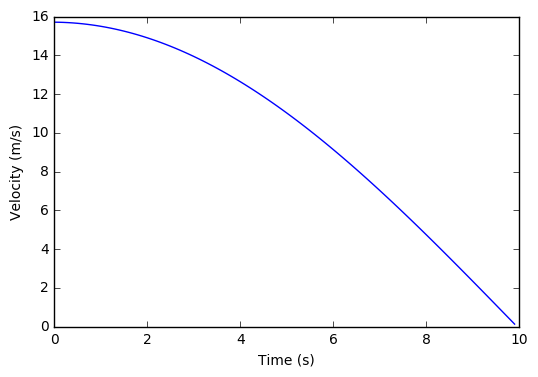

In [386]:
# Take a look at velocity
velocity = 1/h * np.diff(displacement)
# Plot
plt.plot(time[0:N], velocity)
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")

Similarly the acceleration of a particle is the derivative of velocity with respect to time, or the second derivative with respect to position:

$\Large a(t) = \frac{d}{dt} v(t) = \frac{d^2}{dt^2} s(t)$

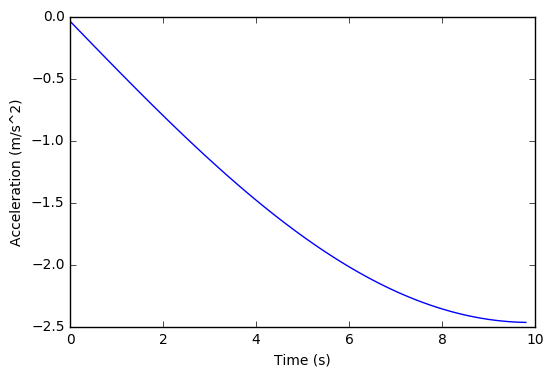

In [387]:
# And now acceleration
accel = 1/h * np.diff(velocity)
# Plot
plt.plot(time[0:N-1], accel)
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s^2)")

## Measurement noise
An accelerometer attached to the particle should look like the above. However, the output is subject to **measurement noise**:

$\Large a_{measured}(t) = a(t) + w(t)$

where $w(t)$ is an AWGN (Additive White **Gaussian** Noise) sequence. We will see what this means for our inertial navigation idea.

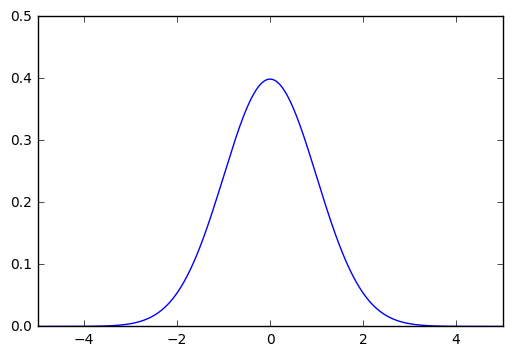

In [388]:
# What is Gaussian noise?
noise_mean = 0
noise_var = 1
stats.plot_gaussian_pdf(mean=noise_mean, variance=noise_var, xlim=(-5, 5), ylim=(0, .5))

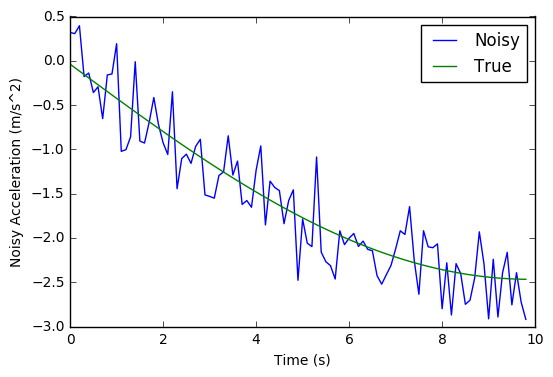

In [389]:
# Add the noise to the accelerometer readings
noise_var = 1e-1
noise = np.sqrt(noise_var) * np.random.randn(N-1)
accel_noisy = accel + noise
# Plot
plt.plot(time[0:N-1], accel_noisy)
plt.plot(time[0:N-1], accel)
plt.xlabel("Time (s)")
plt.ylabel("Noisy Acceleration (m/s^2)")
plt.legend(['Noisy', 'True'])

We know that we should be able to integrate the acceleration, once for velocity and again for position:

$\Large v(t) = \int_0^T a(t) \; \mathrm{d} t + v_0$

$\Large s(t) = \int_0^T v(t) \; \mathrm{d} t + s_0 = \int \left ( \int_0^T a(t) \; dt + v_0 \right ) \; dt + s_0$

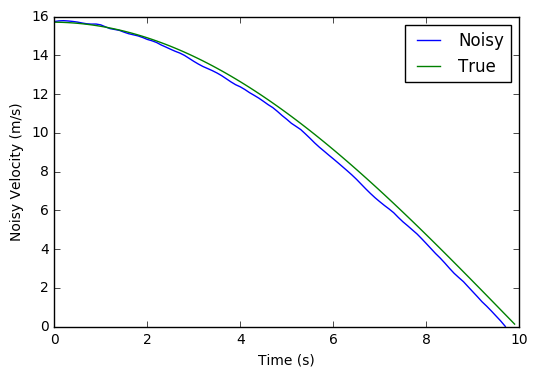

In [390]:
# Integrate this back up to velocity
velocity_noisy = trapz(accel_noisy, time[0:N-1]) + velocity[0]
# Plot
plt.plot(time[0:N-2], velocity_noisy)
plt.plot(time[0:N], velocity)
plt.xlabel("Time (s)")
plt.ylabel("Noisy Velocity (m/s)")
plt.legend(['Noisy', 'True'])

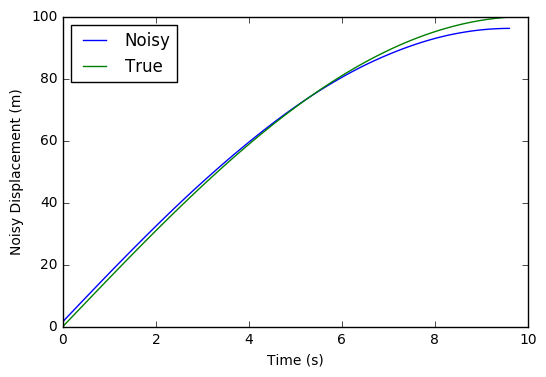

In [391]:
# And now position
displacement_noisy = trapz(velocity_noisy, time[0:N-2]) + displacement[0]
# Plot
plt.plot(time[0:N-3], displacement_noisy)
plt.plot(time[0:N+1], displacement)
plt.xlabel("Time (s)")
plt.ylabel("Noisy Displacement (m)")
plt.legend(['Noisy', 'True'], loc=2)

In fact, the noise is not zero mean (i.e. not white, but has an **offset** which is within some specified range, e.g. $\pm 150mg$, but unknown in each axis. 

Let's see what happens if we assume the accelerometer readings have an offset of $100mg$ in the axis in which our particle moves.

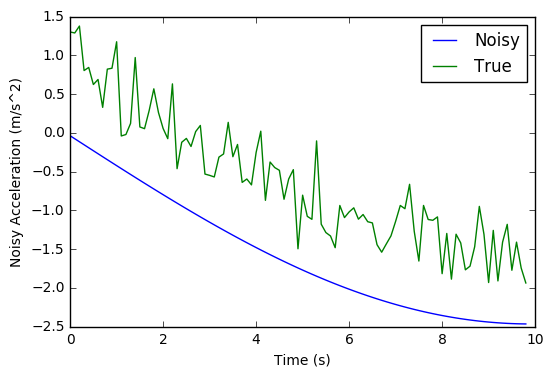

In [392]:
g = 9.81
accel_offset = accel_noisy + 0.1 * g
# Plot
plt.plot(time[0:N-1], accel)
plt.plot(time[0:N-1], accel_offset)
plt.xlabel("Time (s)")
plt.ylabel("Noisy Acceleration (m/s^2)")
plt.legend(['Noisy', 'True'], loc=1)

Final error 43m (43%)


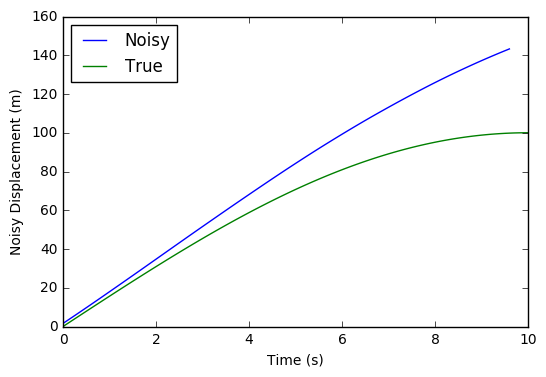

In [393]:
# To position
velocity_offset = trapz(accel_offset, time[0:N-1]) + velocity[0]
displacement_offset = trapz(velocity_offset, time[0:N-2]) + displacement[0]
print("Final error %dm (%d%%)" % (abs(displacement_offset[-1] - displacement[-1]), \
                                  100*abs(displacement_offset[-1]-displacement[-1])/displacement[-1]))
# Plot
plt.plot(time[0:N-3], displacement_offset)
plt.plot(time[0:N+1], displacement)
plt.xlabel("Time (s)")
plt.ylabel("Noisy Displacement (m)")
plt.legend(['Noisy', 'True'], loc=2)

What happens if we don't know $v_0$ accurately? Let us assume a 10% overestimate.

Final error 58m (58%)


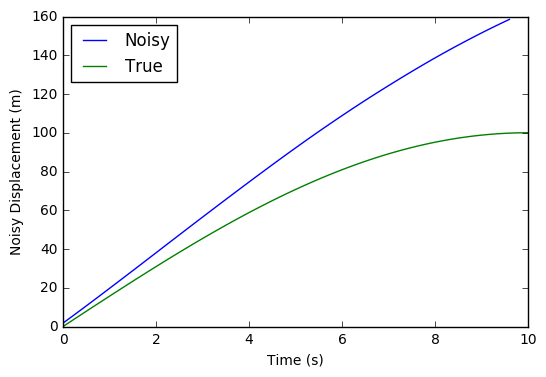

In [394]:
v0_wrong = velocity[0] * 1.1
velocity_v0 = trapz(accel_offset, time[0:N-1]) + v0_wrong
displacement_v0 = trapz(velocity_v0, time[0:N-2]) + displacement[0]
print("Final error %dm (%d%%)" % (abs(displacement_v0[-1] - displacement[-1]), \
                                  100*abs(displacement_v0[-1]-displacement[-1])/displacement[-1]))
# Plot
plt.plot(time[0:N-3], displacement_v0)
plt.plot(time[0:N+1], displacement)
plt.xlabel("Time (s)")
plt.ylabel("Noisy Displacement (m)")
plt.legend(['Noisy', 'True'], loc=2)